<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/practicals/P1.2_Word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Practical Overview

 In this Practical you will learn :
- Basic concepts of word embeddings.
- How to extract word embeddings by N-Gram in a toy example.
- How to extract word embeddings by CBoW in a toy example.
- How to extract word embeddings by CBoW in `Alice in Wonderland`.
- How to perform the analogy task.




# Word Embeddings: Encoding Lexical Semantics


Word embeddings are dense vectors of real numbers, one per word in your
vocabulary. In NLP, it is almost always the case that your features are
words! But how should you represent a word in a computer? You could
store its ascii character representation, but that only tells you what
the word *is*, it doesn't say much about what it *means* (you might be
able to derive its part of speech from its affixes, or properties from
its capitalization, but not much). Even more, in what sense could you
combine these representations? We often want dense outputs from our
neural networks, where the inputs are $|V|$ dimensional, where
$V$ is our vocabulary, but often the outputs are only a few
dimensional (if we are only predicting a handful of labels, for
instance). How do we get from a massive dimensional space to a smaller
dimensional space?

How about instead of ascii representations, we use a one-hot encoding?
That is, we represent the word $w$ by
$$
\begin{align}
\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}
\end{align}
$$

where the 1 is in a location unique to $w$. Any other word will
have a 1 in some other location, and a 0 everywhere else.

There is an enormous drawback to this representation, besides just how
huge it is. It basically treats all words as independent entities with
no relation to each other. What we really want is some notion of
*similarity* between words. Why? Let's see an example.

Suppose we are building a language model. Suppose we have seen the
sentences

* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

in our training data. Now suppose we get a new sentence never before
seen in our training data:

* The physicist solved the open problem.

Our language model might do OK on this sentence, but wouldn't it be much
better if we could use the following two facts:

- We have seen  mathematician and physicist in the same role in a sentence. Somehow they
  have a semantic relation.
* We have seen mathematician in the same role  in this new unseen sentence
  as we are now seeing physicist.

and then infer that physicist is actually a good fit in the new unseen
sentence? This is what we mean by a notion of similarity: we mean
*semantic similarity*, not simply having similar orthographic
representations. It is a technique to combat the sparsity of linguistic
data, by connecting the dots between what we have seen and what we
haven't. This example of course relies on a fundamental linguistic
assumption: that words appearing in similar contexts are related to each
other semantically. This is called the [distributional
hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics).


# Getting Dense Word Embeddings


How can we solve this problem? That is, how could we actually encode
semantic similarity in words? Maybe we think up some semantic
attributes. For example, we see that both mathematicians and physicists
can run, so maybe we give these words a high score for the "is able to
run" semantic attribute. Think of some other attributes, and imagine
what you might score some common words on those attributes.

If each attribute is a dimension, then we might give each word a vector,
like this:

$$
\begin{align}
q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
   \overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]
 \end{align}
$$

$$
\begin{align}
q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
   \overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]
\end{align}
$$

Then we can get a measure of similarity between these words by doing:

$$
\begin{align}
\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}
\end{align}
$$


Although it is more common to normalize by the lengths:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
   {\| q_\text{physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)\end{align}

Where $\phi$ is the angle between the two vectors. That way,
extremely similar words (words whose embeddings point in the same
direction) will have similarity 1. Extremely dissimilar words should
have similarity -1.



You can think of the sparse one-hot vectors from the beginning of this
section as a special case of these new vectors we have defined, where
each word basically has similarity 0, and we gave each word some unique
semantic attribute. These new vectors are *dense*, which is to say their
entries are (typically) non-zero.

But these new vectors are a big pain: you could think of thousands of
different semantic attributes that might be relevant to determining
similarity, and how on earth would you set the values of the different
attributes? Central to the idea of deep learning is that the neural
network learns representations of the features, rather than requiring
the programmer to design them herself. So why not just let the word
embeddings be parameters in our model, and then be updated during
training? This is exactly what we will do. We will have some *latent
semantic attributes* that the network can, in principle, learn. Note
that the word embeddings will probably not be interpretable. That is,
although with our hand-crafted vectors above we can see that
mathematicians and physicists are similar in that they both like coffee,
if we allow a neural network to learn the embeddings and see that both
mathematicians and physicists have a large value in the second
dimension, it is not clear what that means. They are similar in some
latent semantic dimension, but this probably has no interpretation to
us.


In summary, **word embeddings are a representation of the *semantics* of
a word, efficiently encoding semantic information that might be relevant
to the task at hand**. You can embed other things too: part of speech
tags, parse trees, anything! The idea of feature embeddings is central
to the field.


# Word Embeddings in Pytorch


Before we get to a worked example and an exercise, a few quick notes
about how to use embeddings in Pytorch and in deep learning programming
in general. Similar to how we defined a unique index for each word when
making one-hot vectors, we also need to define an index for each word
when using embeddings. These will be keys into a lookup table. That is,
embeddings are stored as a $|V| \times D$ matrix, where $D$
is the dimensionality of the embeddings, such that the word assigned
index $i$ has its embedding stored in the $i$'th row of the
matrix. In all of code, the mapping from words to indices is a
dictionary named word\_to\_ix.

The module that allows you to use embeddings is torch.nn.Embedding,
which takes two arguments: the vocabulary size, and the dimensionality
of the embeddings.

To index into this table, you must use torch.LongTensor (since the
indices are integers, not floats).



In [2]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
torch.manual_seed(1)

In [28]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[-2.3264,  1.6169, -0.9026,  0.1737,  0.0772]],
       grad_fn=<EmbeddingBackward>)


# Example  N-Gram Language Modeling in a Toy example


Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute

\begin{align}P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )\end{align}

Where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.




##  Data Preprocessing

Before we can use the data in our model, we should build a list of tuples.  Each tuple is `([ word_i-2, word_i-1 ], target word)`, we also build dictionaries to map from words to indices, i.e. word_to_ix, and map from indices to words, i.e. ix_to_word,

In [91]:
CONTEXT_SIZE = 2

# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])


vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}


[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]


## Create N-Gram model
We create N-Gram language model, and set the word embedding size to be 100 (or other by your preferance)

In [92]:
EMBEDDING_DIM = 100

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs



loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(100):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    average_loss= total_loss/len(trigrams)
    print('Epoch:', epoch, '\tLoss:', average_loss)  # The loss decreased every iteration over the training data!

Epoch: 0 	Loss: 4.626365231201712
Epoch: 1 	Loss: 4.575700713469919
Epoch: 2 	Loss: 4.525661622528482
Epoch: 3 	Loss: 4.476208777554267
Epoch: 4 	Loss: 4.427311705277029
Epoch: 5 	Loss: 4.3789082987118615
Epoch: 6 	Loss: 4.330896957785682
Epoch: 7 	Loss: 4.2831628428096264
Epoch: 8 	Loss: 4.23555365916902
Epoch: 9 	Loss: 4.188187324895268
Epoch: 10 	Loss: 4.140882053206452
Epoch: 11 	Loss: 4.09372252911593
Epoch: 12 	Loss: 4.046565714135634
Epoch: 13 	Loss: 3.999197877613844
Epoch: 14 	Loss: 3.9516022163154805
Epoch: 15 	Loss: 3.9037622477101013
Epoch: 16 	Loss: 3.8555072451059798
Epoch: 17 	Loss: 3.806986528160298
Epoch: 18 	Loss: 3.7581329282406157
Epoch: 19 	Loss: 3.708921892453084
Epoch: 20 	Loss: 3.6593494963856923
Epoch: 21 	Loss: 3.609248336437529
Epoch: 22 	Loss: 3.558551379009686
Epoch: 23 	Loss: 3.5074366637035808
Epoch: 24 	Loss: 3.4557576432692265
Epoch: 25 	Loss: 3.4035739476701856
Epoch: 26 	Loss: 3.350859136708015
Epoch: 27 	Loss: 3.297844743306658
Epoch: 28 	Loss: 3.244

##  Check the results

We can print the word embedding value by creating pandas table

In [33]:
import pandas as pd
embeddings = model.embeddings(torch.Tensor([list(range(0,len(vocab)))]).long())
embeddings = embeddings.view(-1,EMBEDDING_DIM)
pd.DataFrame(embeddings.tolist(), index=list(ix_to_word.values())[0:]).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
more,1.320313,0.828640,-1.312770,-0.359023,-0.481240,1.627352,1.056634,0.530470,-0.042100,-1.124597,...,-0.391645,-0.414608,-1.142812,1.180725,0.287632,0.175876,-0.964193,0.748175,-0.002119,1.344552
"field,",0.085171,-0.335934,-0.001619,0.523827,-0.862167,-0.304661,0.630433,0.363044,0.559629,1.664607,...,1.692478,0.184778,0.863177,-0.286952,0.201761,-0.041516,1.153544,0.287470,0.276546,-0.939250
"asked,",-0.904634,-0.511664,-1.230640,1.028239,0.185730,0.373448,0.488494,-0.203774,0.902683,-0.513498,...,-0.248238,0.510158,-0.151632,-0.656623,-0.512230,1.119200,0.288812,0.597171,-1.254859,-1.938549
thine!,0.917796,-0.544285,-2.358330,-1.520604,0.387231,1.644806,0.008153,2.236723,2.123309,-0.914316,...,1.750600,-0.573296,-0.137342,0.326746,-0.934264,-0.519515,0.230680,-0.257850,-0.985312,0.098289
blood,0.393552,0.069178,0.522326,-1.987879,0.512980,0.918553,1.045777,-0.442237,-0.772400,-1.125736,...,-0.463219,0.522639,-0.183036,-0.418283,-1.665190,0.568302,2.224463,-1.163765,-0.293115,-0.577371


We can also plot the TSNE to visualize the similarity

In [34]:
labels=[]
for i in range(len(ix_to_word)):
    labels.append(ix_to_word[i])

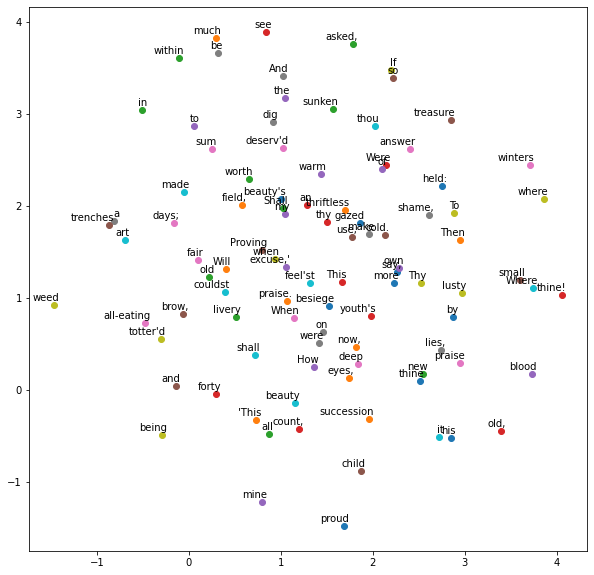

In [35]:
from matplotlib import pylab
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
two_d_embeddings = tsne.fit_transform(embeddings.detach().numpy())

def plot(embeddings, labels):
      assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
      pylab.figure(figsize=(10,10))  # in inches
      for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
      pylab.show()


plot(two_d_embeddings, labels)

In [36]:
context = ['When','forty']

a = model(torch.tensor([word_to_ix[w] for w in context]))

#Print result
print(f'Raw text: {" ".join(test_sentence)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Raw text: When forty winters shall besiege thy brow, And dig deep trenches in thy beauty's field, Thy youth's proud livery so gazed on now, Will be a totter'd weed of small worth held: Then being asked, where all thy beauty lies, Where all the treasure of thy lusty days; To say, within thine own deep sunken eyes, Were an all-eating shame, and thriftless praise. How much more praise deserv'd thy beauty's use, If thou couldst answer 'This fair child of mine Shall sum my count, and make my old excuse,' Proving his beauty by succession thine! This were to be new made when thou art old, And see thy blood warm when thou feel'st it cold.

Context: ['When', 'forty']

Prediction: winters


# Practical. 1: Computing Word Embeddings: Continuous Bag-of-Words in a Toy example



The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize,

$$
\begin{align}
-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)
\end{align}
$$

where $q_w$ is the embedding for word $w$.

Implement this model in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.




##  Data Preprocessing

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). Considering a simple sentence, `the quick brown fox jumps over the lazy dog`, this can be pairs of (context_window, target_word) where if we consider a context size 2 (2 words to the left, 2 to the right),  we have examples like `([the, quick, fox, jumps], brown)` and so on. Thus the model tries to predict the target_word based on the context_window words.


Therefore should build a list of tuples.  Each tuple is `([ word_i-2, word_i-1,word_i+1, word_i+2 ], target word)`, we also build dictionaries to map from words to indices, i.e. word_to_ix, and map from indices to words, i.e. ix_to_word,

In [94]:
import torch
import torch.nn as nn


CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 100

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()


# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = raw_text[i-CONTEXT_SIZE:i] + raw_text[i+1:i+1+CONTEXT_SIZE]
    target = raw_text[i]
    data.append((context, target))
    
print(data[:5])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]



## Create CBoW Model
Following is an image to illustrate the model architecture. We set the word embedding size to be 100 (or other by your preference).

![avatar](https://miro.medium.com/max/328/1*bkrBASpteKfCaxZDEEeN6g.png)

In [60]:
type(data[0][1])

str

In [125]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation2 = nn.LogSoftmax(dim=-1)

    def forward(self, inputs):
        out = sum(self.embedding(inputs)).view((1, -1))
        out = self.linear1(out)
        out = self.activation1(out)
        out = self.linear2(out)
        out = self.activation2(out)
        return out

def make_ix_vector(words, word_to_ix=word_to_ix):
    if type(words) is str:
        idxs = [word_to_ix[words]]
    else:
        idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


model = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
loss_function = nn.NLLLoss()
opt = optim.SGD(model.parameters(), lr=0.001)

#TRAINING
for epoch in range(50):
    total_loss = 0
    total_correct = 0
    for context, target in data:
        context_ix = make_ix_vector(context)
        target_ix = make_ix_vector(target)
        model.zero_grad()

        log_probs = model(context_ix)
        loss = loss_function(log_probs, target_ix)
        if torch.argmax(log_probs[0]).item() == target_ix:
            total_correct += 1

        loss.backward()
        opt.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data)
    acc = total_correct / len(data)
    print(f'EPOCH {epoch:02d} | avg_loss {avg_loss:.4f} | accuracy {acc:.4f}')

EPOCH 00 | avg_loss 3.9923 | accuracy 0.0000
EPOCH 01 | avg_loss 3.8627 | accuracy 0.0172
EPOCH 02 | avg_loss 3.7387 | accuracy 0.0862
EPOCH 03 | avg_loss 3.6193 | accuracy 0.1207
EPOCH 04 | avg_loss 3.5032 | accuracy 0.1379
EPOCH 05 | avg_loss 3.3898 | accuracy 0.2069
EPOCH 06 | avg_loss 3.2787 | accuracy 0.2414
EPOCH 07 | avg_loss 3.1687 | accuracy 0.3103
EPOCH 08 | avg_loss 3.0607 | accuracy 0.4138
EPOCH 09 | avg_loss 2.9556 | accuracy 0.4655
EPOCH 10 | avg_loss 2.8523 | accuracy 0.4655
EPOCH 11 | avg_loss 2.7513 | accuracy 0.4828
EPOCH 12 | avg_loss 2.6518 | accuracy 0.5000
EPOCH 13 | avg_loss 2.5536 | accuracy 0.5000
EPOCH 14 | avg_loss 2.4572 | accuracy 0.5690
EPOCH 15 | avg_loss 2.3625 | accuracy 0.6034
EPOCH 16 | avg_loss 2.2695 | accuracy 0.6379
EPOCH 17 | avg_loss 2.1780 | accuracy 0.6552
EPOCH 18 | avg_loss 2.0881 | accuracy 0.7241
EPOCH 19 | avg_loss 1.9998 | accuracy 0.7586
EPOCH 20 | avg_loss 1.9132 | accuracy 0.7759
EPOCH 21 | avg_loss 1.8285 | accuracy 0.7759
EPOCH 22 |

##  Check the results

Then we check the results by making predictions of target work by context

In [71]:
context = ['People','create','to', 'direct']
context_vector = make_ix_vector(context, word_to_ix)
a = model(context_vector)

#Print result
print(f'Raw text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Raw text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.

Context: ['People', 'create', 'to', 'direct']

Prediction: programs


# Practical. 2: Computing Word Embeddings in  `Alice in Wonderland` using CBoW

Now let's try to build word embedding in a  ‘Alice in Wonderland’ instead of a toy example.  Download the word-label mapping dictionaries and corpus by this [link](https://drive.google.com/drive/folders/1mYM29PbWQ4rS0bgKndFJjZlkbcwMaEpO?usp=sharing), and upload them into your own google drive. After that, mount them to the drive folder so we can use them in colab by:

##  Data Preprocessing

In [ ]:
# from google.colab import drive
# !mkdir drive
# drive.mount('drive')

Then we list all the data in your drive to see if we mount successfully.

In [ ]:
# !ls "drive/My Drive/"

In [3]:
# modify the path according to your own file location
import os
data_path=os.path.join("Word_embedding_data/")

Then we load the data

In [4]:
import json
with open(os.path.join(data_path,"alice.json"),'r') as f:
    alice = json.load(f)
with open(os.path.join(data_path,"ix_to_word.json"),'r') as f:
    ix_to_word = json.load(f)
with open(os.path.join(data_path,"word_to_ix.json"),'r') as f:
    word_to_ix = json.load(f)

Then we create the context and target pair with the help of keras function, we set the window_size 2 (2 words to the left, 2 to the right)

In [5]:
window_size=2
vocab_size=len(word_to_ix)

from keras.preprocessing import text
from keras.preprocessing import sequence

corpus = [[word_to_ix[w] for w in text.text_to_word_sequence(doc)] for doc in alice]

def generate_context_word_pairs(corpus, window_size, vocab_size):
    X = []
    Y = []
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):           
            start = index - window_size
            end = index + window_size + 1
            context = [words[i] for i in range(start, end)if 0 <= i < sentence_length and i != index]
            x = sequence.pad_sequences([context], maxlen=context_length)[0]
            X.append(x)
            Y.append([word])

    X=torch.tensor(X, dtype=torch.long)
    Y=torch.tensor(Y, dtype=torch.long)
    return X,Y

X,Y = generate_context_word_pairs(corpus, window_size=window_size, vocab_size=vocab_size)


##  Create CBoW Model
Now we create CBoW model, we could set the word embedding size to be 100 (or other by your preference).

In [6]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
         super(CBOW, self).__init__()
         self.embedding = nn.Embedding(vocab_size, embedding_dim)
         self.linear1 = nn.Linear(embedding_dim, 128)
         self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
         out = sum(self.embedding(inputs)).view((1, -1))
         out = F.relu(self.linear1(out))
         out = self.linear2(out)
         return F.log_softmax(out, dim=1)
    
    
EMBEDDING_DIM=100
model = CBOW(vocab_size, EMBEDDING_DIM, window_size)

Remember to move your model to GPU because now we are training with a lot of corpus.

In [7]:
# Move model to GPU
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(dev)

CBOW(
  (embedding): Embedding(2379, 100)
  (linear1): Linear(in_features=100, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=2379, bias=True)
)

Then we train the model and print the loss. Loss should decrease every iteration over the training data. Play with the epochs numbers here, recommend 200 or above.

In [9]:
loss_function = nn.NLLLoss()
opt = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(200):
    total_loss = 0
    total_correct = 0
    for context, target in zip(X, Y):
        model.zero_grad()

        log_probs = model(context.to(dev))
        loss = loss_function(log_probs, target.to(dev))
        if torch.argmax(log_probs[0]).item() == target:
            total_correct += 1

        loss.backward()
        opt.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(X)
    acc = total_correct / len(X)
    print(f'EPOCH {epoch:03d} | avg_loss {avg_loss:.4f} | accuracy {acc:.4f}')

EPOCH 000 | avg_loss 6.3433 | accuracy 0.0737
EPOCH 001 | avg_loss 6.1804 | accuracy 0.0806
EPOCH 002 | avg_loss 6.0189 | accuracy 0.0893
EPOCH 003 | avg_loss 5.8567 | accuracy 0.0961
EPOCH 004 | avg_loss 5.6900 | accuracy 0.1033
EPOCH 005 | avg_loss 5.5164 | accuracy 0.1125
EPOCH 006 | avg_loss 5.3351 | accuracy 0.1240
EPOCH 007 | avg_loss 5.1457 | accuracy 0.1358
EPOCH 008 | avg_loss 4.9490 | accuracy 0.1476
EPOCH 009 | avg_loss 4.7456 | accuracy 0.1604
EPOCH 010 | avg_loss 4.5365 | accuracy 0.1772
EPOCH 011 | avg_loss 4.3233 | accuracy 0.1947
EPOCH 012 | avg_loss 4.1074 | accuracy 0.2160
EPOCH 013 | avg_loss 3.8905 | accuracy 0.2380
EPOCH 014 | avg_loss 3.6749 | accuracy 0.2642
EPOCH 015 | avg_loss 3.4631 | accuracy 0.2961
EPOCH 016 | avg_loss 3.2570 | accuracy 0.3299
EPOCH 017 | avg_loss 3.0592 | accuracy 0.3687
EPOCH 018 | avg_loss 2.8716 | accuracy 0.4061
EPOCH 019 | avg_loss 2.6965 | accuracy 0.4407
EPOCH 020 | avg_loss 2.5349 | accuracy 0.4738
EPOCH 021 | avg_loss 2.3870 | accu

# Practical. 3: Analogy Task




**Reading material**
* [1] Mikolov, Tomas, et al. "[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)" Advances in neural information processing systems. 2013. 


Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in [1]. Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. 

In a perfect scenario, we would like that this analogy ($e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. The result of the formula is called the expected or the predicted word embedding. In this context, "man" is called the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.  

You have to answer an analogy function using each embedding for  CBOW model. Show the true word (with distance similarity value between predicted embedding and true word embedding, i.e. `sim1`) , the predicted word (with distance similarity value between predicted embedding and the embedding of the word in the vocabulary that is closest to this predicted embedding, i.e. `sim2`).

Since `Alice in wonder land` is a relatively small dataset to training the model for the analogy task,  we may find it is difficult to get the correct answer by searching the nearest word embedding. Therefore, we extend the predicted word to the nearest `nr` number of words and check if the true word is within them. Do not expect the `nr` to be very small, it could be hundreds.



<b>HINT</b>: to visualize the results of the analogy tasks , you can print them in a table. An example is given below.


| Analogy task | True word (sim1)  | Predicted nearaest word (sim2) | Correct? |True word within the top `nr` nearest word?|
|:------:|:------:|:------:|:------:|:------:|
|  queen is to king as woman is to ?	 | man (sim1) | predictd_word(sim2) | True / False |   True / False|

In [8]:
analogy=('queen', 'king', 'woman', 'man')

First let us extract the embeddings of all vocabularies for the following task

In [9]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
embeddings = model.embedding(torch.Tensor([list(range(0,vocab_size))]).long().to(dev))
embeddings = embeddings.view(-1,100)
embeddings = embeddings.cpu().detach().numpy()

Then we define a 'get_nearest_words' function to retrive the nearest `nr` words to a certain word embedding

In [19]:
from sklearn.metrics import pairwise

def get_nearest_words(target, embs, nr):
    sims = pairwise.cosine_similarity([target], embeddings).reshape(-1)
    nearest_ixs = np.flip(sims.argsort())[:nr]
    return nearest_ixs

Now let's search for the nearest `one` and `nr` words of the predicted word embedding, and print results of the analogy tasks

In [51]:
def print_analogy(analogy, nr=100, print_nearest=False):
    analogy_ixs = [word_to_ix[word] for word in analogy]
    analogy_embeds = [embeddings[ix] for ix in analogy_ixs]
    target = analogy_embeds[0] - analogy_embeds[1] + analogy_embeds[2]
    pred_nearest_ixs = get_nearest_words(target, embeddings, nr)
    pred_word = ix_to_word[str(pred_nearest_ixs[0])]
    is_within_nearest_nr = word_to_ix[analogy[3]] in pred_nearest_ixs

    print(f'Analogy task: {analogy[0]} is to {analogy[1]} as {analogy[2]} is to ?')
    print(f'True word: {analogy[3]}')
    print(f'Predicted word: {pred_word}')
    print(f'Correct: {pred_word == analogy[3]}')
    print(f'Is within nearest `nr` predicted words: {is_within_nearest_nr}')
    if print_nearest:
        print('Nearest words:')
        for ix in pred_nearest_ixs:
            print(f'- {ix_to_word[str(ix)]}')

In [53]:
print_analogy(analogy, nr=10, print_nearest=True)

Analogy task: queen is to king as woman is to ?
True word: man
Predicted word: queen
Correct: False
Is within nearest `nr` predicted words: False
Nearest words:
- queen
- woman
- several
- lost
- spreading
- crowd
- bore
- twice
- manners
- useful


In [43]:
all_words = list(word_to_ix.keys())
'smaller' in all_words

True

In [52]:
print_analogy(['larger', 'large', 'small', 'smaller'], nr=10, print_nearest=True)

Analogy task: larger is to large as small is to ?
True word: smaller
Predicted word: larger
Correct: False
Is within nearest `nr` predicted words: True
Nearest words:
- larger
- small
- driest
- label
- arrived
- dogs
- grazed
- smaller
- rightly
- much
